In [1]:
from datetime import date, timedelta
import geopandas, pandas as pd
from constants import *
from download import download
from geo import convert_df
from phe import plot_areas, recent_phe_data_summed, map_data as phe_map_data, plot_map as phe_plot_map
from zoe import latest_map_data as zoe_map_data, bokeh_plot_map as zoe_plot_map, add_simple_geoms
from plotting import matplotlib_zoe_vs_phe_map, geoplot_bokeh, save_to_disk, bokeh_zoe_vs_phe_map
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [32]:
force_download = False
for_date = date.today()-timedelta(days=0)

In [33]:
# download cases data
suffix = 'csv'
for type_ in 'cases', 'deaths':
    path = base_path / f'coronavirus-cases_{for_date}.{suffix}'
    if force_download or not path.exists():
        download(cases_url.format(data_type=suffix), path)

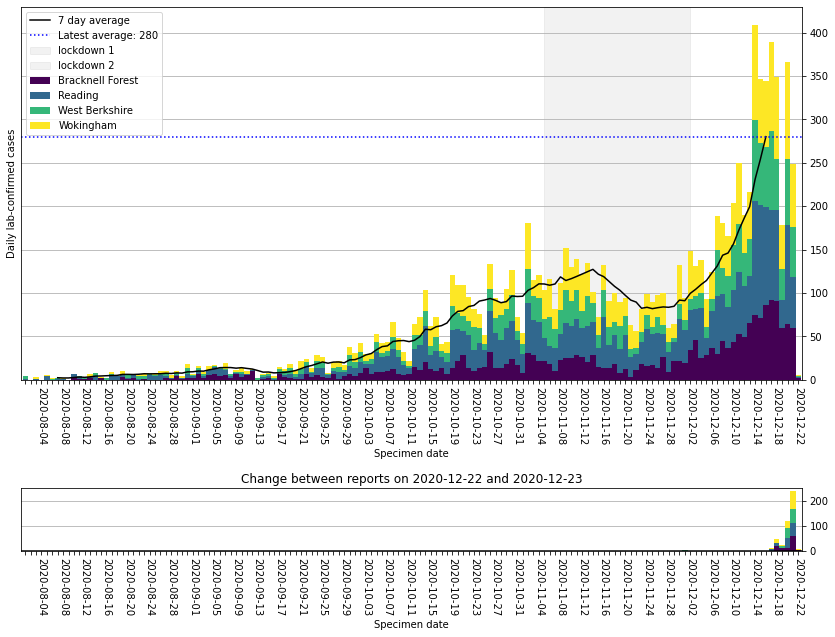

In [34]:
plot_areas(for_date, areas=my_areas, uncertain_days=5, earliest=second_wave)

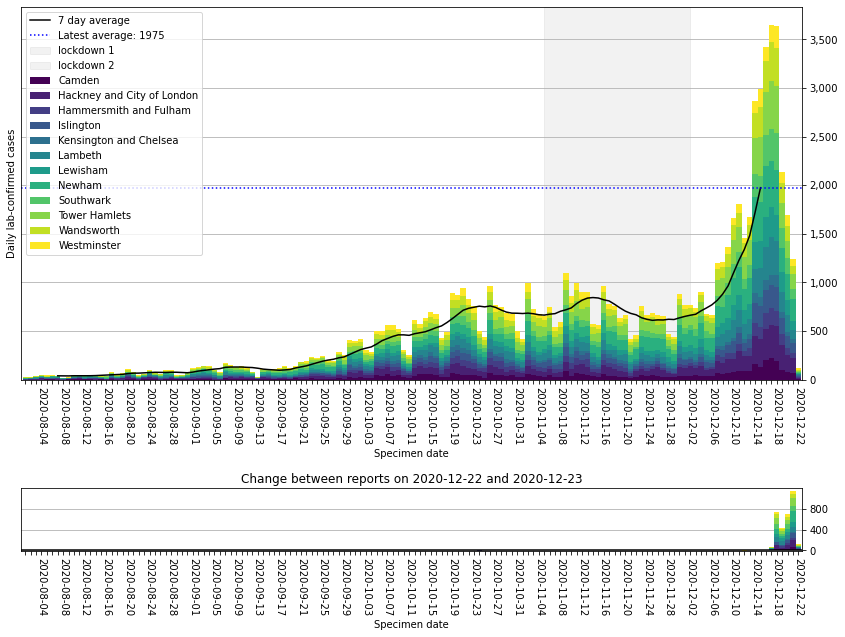

In [35]:
plot_areas(for_date, areas=london_areas, uncertain_days=6, earliest=second_wave)

In [36]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)
top_10 = data.sort_values(per100k, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E07000068,Brentwood,1081.645983,828.0,2020-12-22
E07000072,Epping Forest,1022.594691,1341.0,2020-12-22
E06000034,Thurrock,1012.606869,1747.0,2020-12-22
E09000016,Havering,950.700128,2451.0,2020-12-22
E07000069,Castle Point,923.725991,832.0,2020-12-22
E07000066,Basildon,886.679364,1648.0,2020-12-22
E09000026,Redbridge,869.485088,2642.0,2020-12-22
E06000033,Southend-on-Sea,793.037493,1447.0,2020-12-22
E09000002,Barking and Dagenham,783.969660,1662.0,2020-12-22


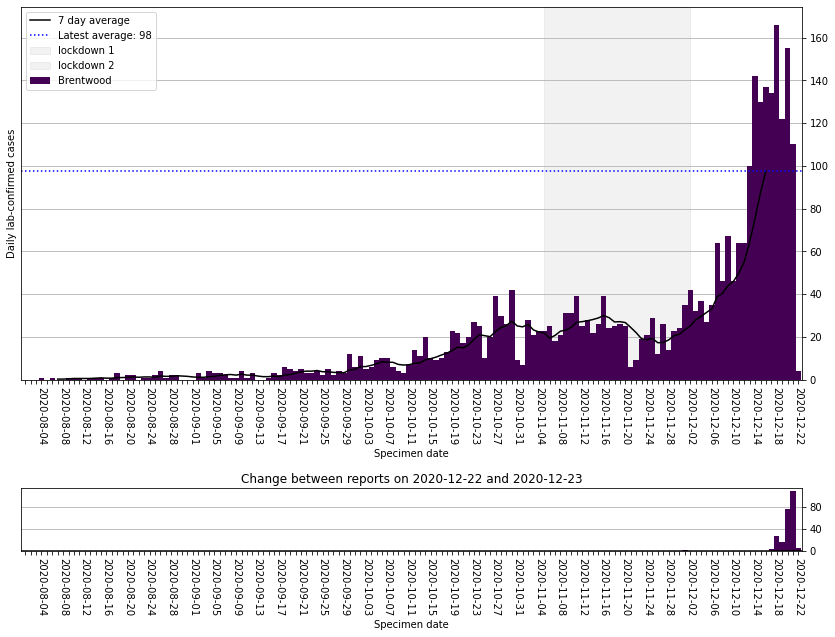

In [37]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [38]:
top_10_types = ltla
data = recent_phe_data_summed(for_date, by=top_10_types)
top_10 = data.sort_values(cases, ascending=False)[:10][[area,per100k,cases,specimen_date]]
top_10

,Area name,"cases per 100,000 people",Daily lab-confirmed cases,Specimen date
Area code,,,,
E08000025,Birmingham,239.360630,2732.0,2020-12-22
E09000026,Redbridge,869.485088,2642.0,2020-12-22
E09000016,Havering,950.700128,2451.0,2020-12-22
E09000025,Newham,629.536512,2216.0,2020-12-22
E09000010,Enfield,657.443488,2195.0,2020-12-22
E06000035,Medway,781.702687,2172.0,2020-12-22
E09000030,Tower Hamlets,638.642766,2029.0,2020-12-22
E09000031,Waltham Forest,722.081677,1998.0,2020-12-22
E09000004,Bexley,779.752323,1928.0,2020-12-22


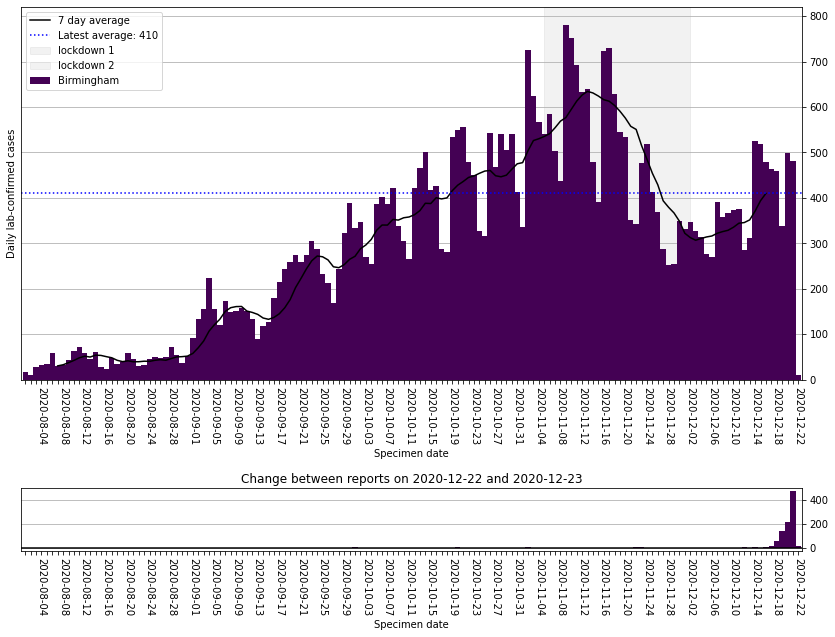

In [39]:
plot_areas(for_date, areas = [top_10.iloc[0].name], area_types=top_10_types, uncertain_days=5, earliest=second_wave)

In [40]:
zoe_date, zoe_df = zoe_map_data()

In [41]:
phe_recent_date, phe_recent_geo, phe_recent_title = phe_map_data(for_date)

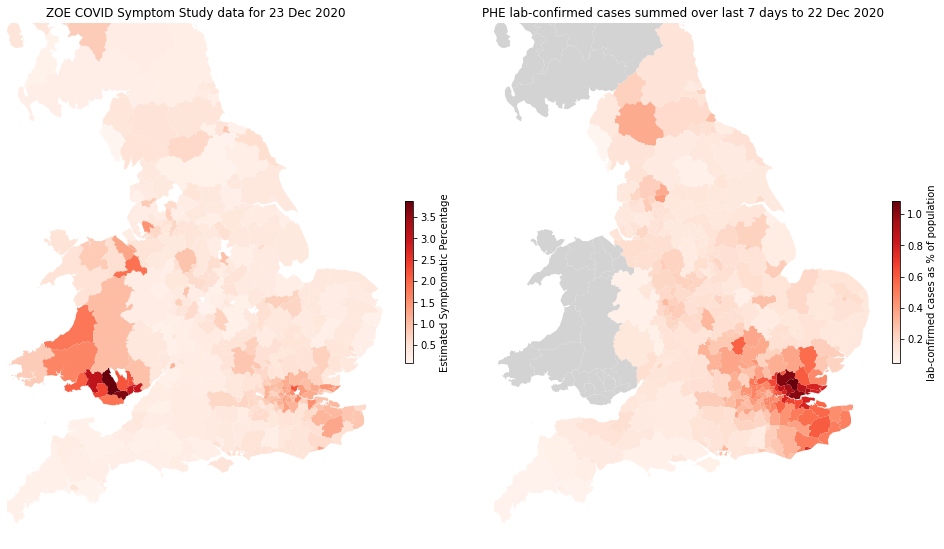

In [42]:
matplotlib_zoe_vs_phe_map(zoe_df, zoe_date, phe_recent_geo, phe_recent_title)   

In [43]:
zoe_new_lad16 = add_simple_geoms(zoe_df)

In [44]:
bokeh_zoe_vs_phe_map(zoe_new_lad16, zoe_date, phe_recent_geo, phe_recent_title)

Loading BokehJS ...

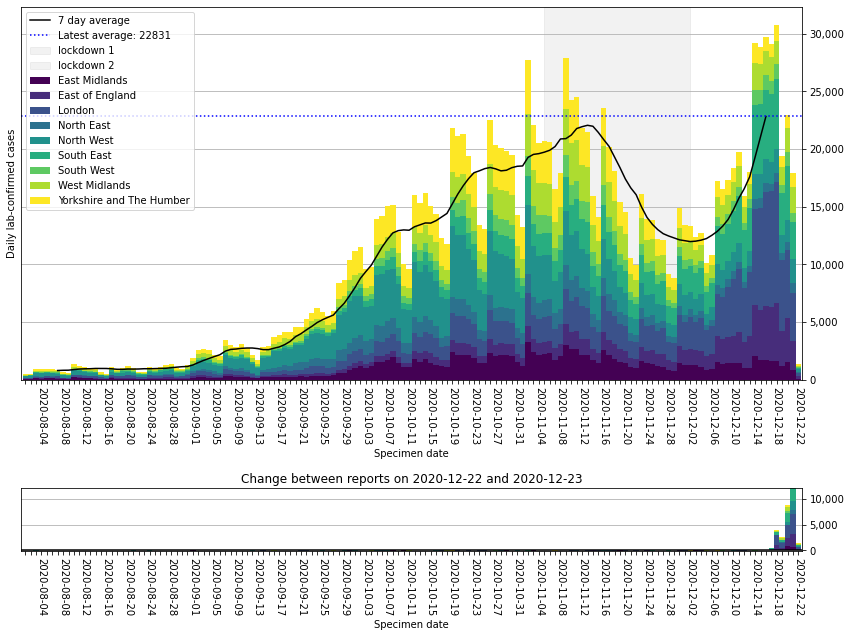

In [45]:
from functools import partial
from phe import plot_with_diff, data_for_date
plot_with_diff(
    for_date-timedelta(days=0),
    partial(data_for_date, area_types=region),
    uncertain_days=5, 
    diff_days=1,
    diff_log_scale=False,
    diff_ylims=[-10, 12_000],
    earliest=second_wave
)